# Seed-Parallel training

Since `PDEquinox` builds on `Equinox` which is just a very thin extension to JAX
PyTrees we can make usage of automatic vectorization (`jax.vmap`) in many
interesting ways.

One particularly efficient use-case is "seed-parallel" training. If your network
does not fully utilize the GPU compute resources, you can train multiple
independent networks (initialized with different seeds) at the same time. The
most naive way would be by spawning multiple JAX processes that each take their
respective share of the GPU. This has two disadvantages:

1. Sharing a GPU between two compute-heavy processes is error-prone.
2. Some tensors are the same among all processes (e.g. the dataset) and would
   have to be duplicated.

If we write the training of the network from the seed to the final trained
network as a (pure) function, we can simply use `jax.vmap` on it. More
precisely, we have to use `eqx.filter_vmap` because the return type is not a
pure PyTree.

In this example, we will train a simple feedfoward ConvNet to become the solver
to the heat equation.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

/tmp/ipykernel_1840730/6392105.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pdequinox as pdeqx

Below is the data generation with the BTCS method. This is not relevant for the
seed-parallel training.

In [3]:
NUM_POINTS = 48
NUM_SAMPLES = 1000
DOMAIN_EXTENT = 3.0
DT = 0.1
DIFFUSIVITY = 0.1

# Grid excludes the two Dirichlet points
grid = jnp.linspace(0, DOMAIN_EXTENT, NUM_POINTS + 2)[1:-1]
dx = grid[1] - grid[0]

laplacian = (
    jnp.diag(jnp.ones(NUM_POINTS - 1), -1)
    - 2 * jnp.diag(jnp.ones(NUM_POINTS), 0)
    + jnp.diag(jnp.ones(NUM_POINTS - 1), 1)
)
laplacian = laplacian / dx**2

system_matrix = jnp.eye(NUM_POINTS) - DIFFUSIVITY * DT * laplacian


def advance_state(u):
    return jnp.linalg.solve(system_matrix, u)


def create_discontinuity(key):
    limit_1_key, limit_2_key = jax.random.split(key)
    lower_limit = jax.random.uniform(
        limit_1_key, (), minval=0.2 * DOMAIN_EXTENT, maxval=0.4 * DOMAIN_EXTENT
    )
    upper_limit = jax.random.uniform(
        limit_2_key, (), minval=0.6 * DOMAIN_EXTENT, maxval=0.8 * DOMAIN_EXTENT
    )

    discontinuity = jnp.where((grid >= lower_limit) & (grid <= upper_limit), 1.0, 0.0)

    return discontinuity


primary_key = jax.random.PRNGKey(0)
keys = jax.random.split(primary_key, NUM_SAMPLES)
initial_states = jax.vmap(create_discontinuity)(keys)
next_states = jax.vmap(advance_state)(initial_states)

# Add a singleton channel axis to be compatible with convolutional layers
initial_states = initial_states[:, None, :]
next_states = next_states[:, None, :]

2024-04-17 10:38:32.010199: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


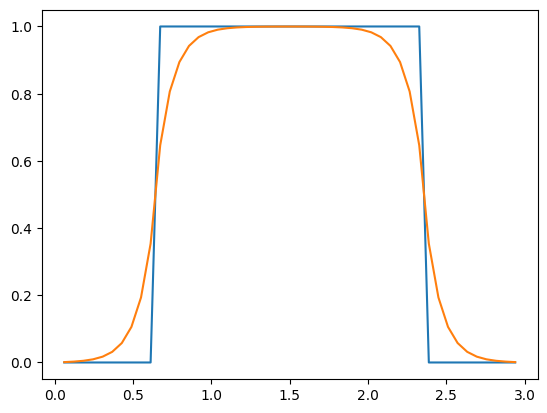

In [4]:
plt.plot(grid, initial_states[0, 0], label="Initial state")
plt.plot(grid, next_states[0, 0], label="Next state")

In [5]:
# 4:1 train-test split
train_size = NUM_SAMPLES // 5 * 4
train_initial_states, test_initial_states = jnp.split(initial_states, [train_size])
train_next_states, test_next_states = jnp.split(next_states, [train_size])

Below is a straightforward training loop for reference

In [6]:
# Training loop
heat_stepper_conv_net = pdeqx.arch.ConvNet(
    1,
    1,
    1,
    hidden_channels=16,
    depth=6,
    activation=jax.nn.relu,
    key=jax.random.PRNGKey(0),
    boundary_mode="dirichlet",
)

parameter_count = pdeqx.count_parameters(heat_stepper_conv_net)
print("Number of parameters: ", parameter_count)

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(heat_stepper_conv_net, eqx.is_array))


def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse


@eqx.filter_jit
def update_fn(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss


loss_history = []
shuffle_key = jax.random.PRNGKey(151)
for epoch in tqdm(range(100)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in pdeqx.dataloader(
        (train_initial_states, train_next_states), batch_size=32, key=subkey
    ):
        heat_stepper_conv_net, opt_state, loss = update_fn(
            heat_stepper_conv_net,
            opt_state,
            *batch,
        )
        loss_history.append(loss)

Number of parameters:  4033


  0%|          | 0/100 [00:00<?, ?it/s]

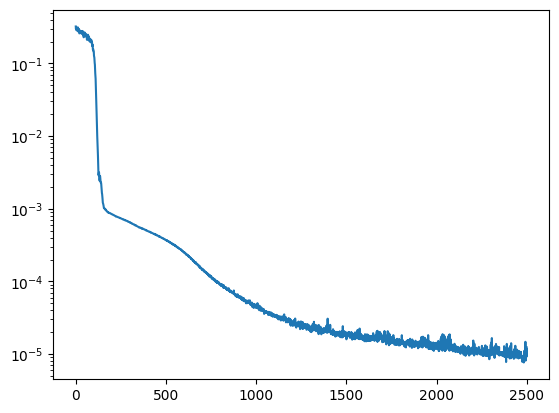

In [7]:
plt.semilogy(loss_history)

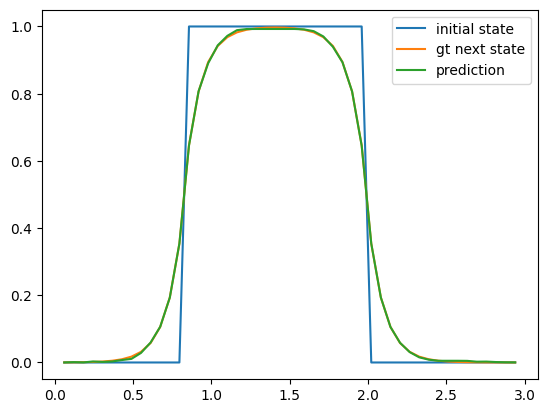

In [8]:
BATCH_I = 5
plt.plot(grid, test_initial_states[BATCH_I, 0], label="initial state")
plt.plot(grid, test_next_states[BATCH_I, 0], label="gt next state")
plt.plot(
    grid, heat_stepper_conv_net(test_initial_states[BATCH_I])[0], label="prediction"
)
plt.legend()

Let's now pack this into a training function that maps a `jax.random.PRNGKey` to
a trained network.

Internally, this key will be used for pseudo-random parts:

1. Initialization of the network
2. Shuffling the dataset

In [9]:
def perform_training(key):
    init_key, shuffle_key = jax.random.split(key)

    heat_stepper_conv_net = pdeqx.arch.ConvNet(
        1,
        1,
        1,
        hidden_channels=16,
        depth=6,
        activation=jax.nn.relu,
        key=init_key,
        boundary_mode="dirichlet",
    )

    optimizer = optax.adam(3e-4)
    opt_state = optimizer.init(eqx.filter(heat_stepper_conv_net, eqx.is_array))

    def loss_fn(model, x, y):
        y_pred = jax.vmap(model)(x)
        mse = jnp.mean(jnp.square(y_pred - y))
        return mse

    @eqx.filter_jit
    def update_fn(model, state, x, y):
        loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, new_state = optimizer.update(grad, state, model)
        new_model = eqx.apply_updates(model, updates)
        return new_model, new_state, loss

    loss_history = []
    for epoch in tqdm(range(100)):
        shuffle_key, subkey = jax.random.split(shuffle_key)

        for batch in pdeqx.dataloader(
            (train_initial_states, train_next_states), batch_size=32, key=subkey
        ):
            heat_stepper_conv_net, opt_state, loss = update_fn(
                heat_stepper_conv_net,
                opt_state,
                *batch,
            )
            loss_history.append(loss)

    loss_history = jnp.array(loss_history)

    return heat_stepper_conv_net, loss_history

First, let's see if the function works for a single key.

In [10]:
heat_stepper_conv_net, loss_history = perform_training(jax.random.PRNGKey(0))

  0%|          | 0/100 [00:00<?, ?it/s]

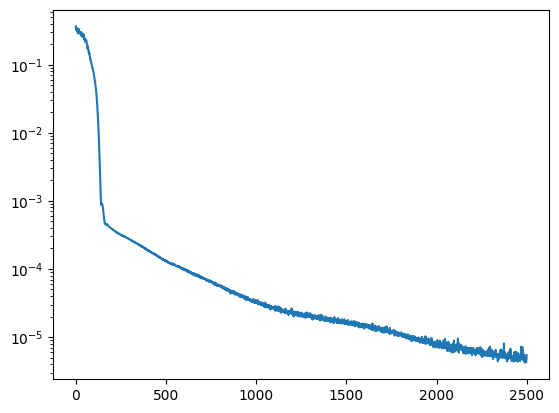

In [11]:
plt.semilogy(loss_history)

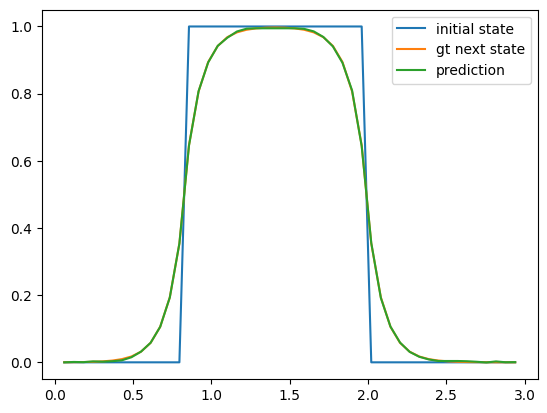

In [12]:
BATCH_I = 5
plt.plot(grid, test_initial_states[BATCH_I, 0], label="initial state")
plt.plot(grid, test_next_states[BATCH_I, 0], label="gt next state")
plt.plot(
    grid, heat_stepper_conv_net(test_initial_states[BATCH_I])[0], label="prediction"
)
plt.legend()

Now, we will train it with ten keys at once. Note that we have to use
`eqx.filter_vmap` instead of `jax.vmap` because the return type is not a pure
PyTree.

The training is now seed-parallel. It takes ~23 seconds to finish on my GPU (RTX
3060), the single training took ~7 seconds. Definitely, there is an overhead but
still we get a speedup of roughly 3x.

In [13]:
keys = jax.random.split(jax.random.PRNGKey(0), 10)
heat_stepper_conv_net_ensemble, loss_history_ensemble = eqx.filter_vmap(
    perform_training
)(keys)

  0%|          | 0/100 [00:00<?, ?it/s]

Note that the returned network ensemble almost has the same PyTree structure as
the original conv net except that all weight arrays have an additional leading
"seed-axis"

In [14]:
heat_stepper_conv_net_ensemble

ConvNet(
  layers=(
    PhysicsConv(
      num_spatial_dims=1,
      weight=f32[10,16,1,3],
      bias=f32[10,16,1],
      in_channels=1,
      out_channels=16,
      kernel_size=(3,),
      stride=(1,),
      padding=((1, 1),),
      padding_mode='zeros',
      dilation=(1,),
      groups=1,
      use_bias=True,
      boundary_mode='dirichlet',
      boundary_kwargs={}
    ),
    PhysicsConv(
      num_spatial_dims=1,
      weight=f32[10,16,16,3],
      bias=f32[10,16,1],
      in_channels=16,
      out_channels=16,
      kernel_size=(3,),
      stride=(1,),
      padding=((1, 1),),
      padding_mode='zeros',
      dilation=(1,),
      groups=1,
      use_bias=True,
      boundary_mode='dirichlet',
      boundary_kwargs={}
    ),
    PhysicsConv(
      num_spatial_dims=1,
      weight=f32[10,16,16,3],
      bias=f32[10,16,1],
      in_channels=16,
      out_channels=16,
      kernel_size=(3,),
      stride=(1,),
      padding=((1, 1),),
      padding_mode='zeros',
      dilation=(1,)

Also the returnd `loss_history_ensemble` will be an array with an additional axis.

In [15]:
loss_history_ensemble

Array([[3.1785610e-01, 3.1318086e-01, 3.1591335e-01, ..., 1.4811711e-05,
        1.4439639e-05, 1.3734620e-05],
       [3.0914205e-01, 3.1700599e-01, 3.1852102e-01, ..., 4.2679380e-06,
        4.4568651e-06, 4.8338584e-06],
       [4.7393119e-01, 4.6301746e-01, 4.4577369e-01, ..., 5.3830390e-06,
        6.9759080e-06, 5.0204699e-06],
       ...,
       [3.6388120e-01, 3.6845502e-01, 3.7639838e-01, ..., 8.4970397e-06,
        8.9812229e-06, 9.3970866e-06],
       [4.2095697e-01, 4.2648774e-01, 4.2377314e-01, ..., 6.7709584e-06,
        6.0324246e-06, 7.7475106e-06],
       [3.1673649e-01, 3.1747985e-01, 3.1582636e-01, ..., 5.5291921e-06,
        5.9626809e-06, 7.6794668e-06]], dtype=float32)

Let's plot the loss history of the ensemble.

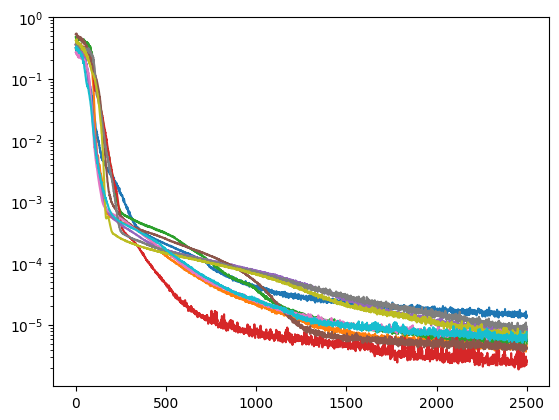

In [16]:
plt.semilogy(loss_history_ensemble.T);

As well as the various predictions of the ensemble, which requires us to execute
the inference forward pass in batch

In [17]:
predictions_ensemble = eqx.filter_vmap(
    lambda model: jax.vmap(model)(test_initial_states)
)(heat_stepper_conv_net_ensemble)

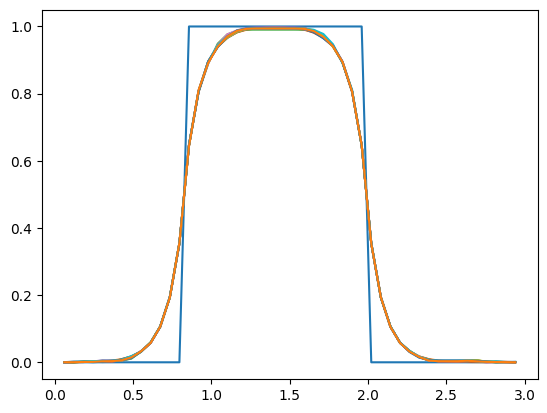

In [18]:
BATCH_I = 5
plt.plot(grid, test_initial_states[BATCH_I, 0], label="initial state")
plt.plot(grid, test_next_states[BATCH_I, 0], label="gt next state")
plt.plot(grid, predictions_ensemble[:, BATCH_I, 0].T, label="prediction");

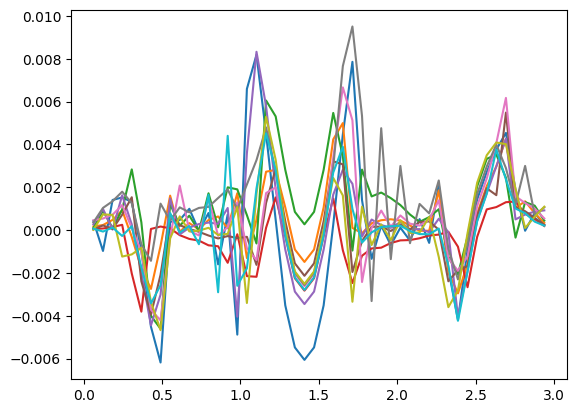

In [19]:
BATCH_I = 5
differences = predictions_ensemble[:, BATCH_I, 0] - test_next_states[BATCH_I, 0]
plt.plot(grid, differences.T);

### Manipulating ensembles

We saw that once we have an ensemble of networks, calling it on new inputs
always requires some juggeling with the filtered vmap of `Equinox`. Let's say,
we are interested in the network associated with seed 4 (index 4 using 0-based
indexing).

In [20]:
heat_stepper_conv_net_seed_4 = pdeqx.extract_from_ensemble(
    heat_stepper_conv_net_ensemble, 4
)

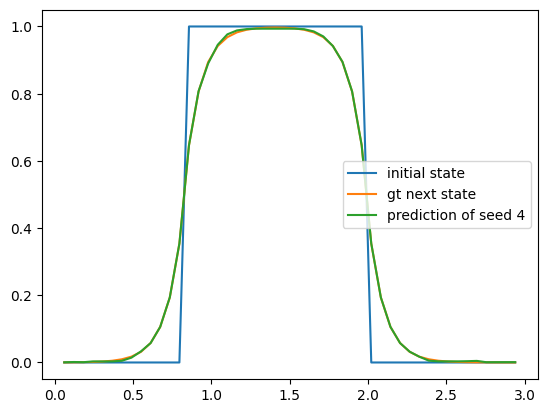

In [21]:
BATCH_I = 5
plt.plot(grid, test_initial_states[BATCH_I, 0], label="initial state")
plt.plot(grid, test_next_states[BATCH_I, 0], label="gt next state")
plt.plot(
    grid,
    heat_stepper_conv_net_seed_4(test_initial_states[BATCH_I])[0],
    label="prediction of seed 4",
)
plt.legend()

Let's say we want to combine seed 4 & 6 into a new ensemble, we could do it like
this

In [22]:
heat_stepper_conv_net_seed_4 = pdeqx.extract_from_ensemble(
    heat_stepper_conv_net_ensemble, 4
)
heat_stepper_conv_net_seed_6 = pdeqx.extract_from_ensemble(
    heat_stepper_conv_net_ensemble, 6
)

heat_stepper_conv_net_ensemble_4_6 = pdeqx.combine_to_ensemble(
    [heat_stepper_conv_net_seed_4, heat_stepper_conv_net_seed_6]
)

If we inspect the shape of its first weight array, we see that the seed axis is
now of size 2.

In [24]:
heat_stepper_conv_net_ensemble_4_6.layers[0].weight.shape

(2, 16, 1, 3)